# Predictive Maintainence

Predictive maintanence helps when a working machine will fail, so that maintanence can be planned in advance. 

The modelling solutions can be categorized into:
* Classification: Predict whether the machine will fail within a certain time frame.
* Regression: Predict the exact Remaining Useful Life (RUL).

We will use the sensory data generated by the Turbofan Engine to predict its RUL.

## Classification Method

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(123)  
PYTHONHASHSEED = 0

%matplotlib inline

 ### Read and Load Data
Data sets consists of multiple multivariate time series. 
Each time series is from a different engine – i.e., the data can be considered to be from a fleet of engines of the same type. 
Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

Data are seperated into Training set and Test Set.
RUL means Remaining Useful Life which indicates how much time before the machine part deteriorate. RUL files are the true labels for the test dataset.

In [0]:
parent_url = 'https://raw.githubusercontent.com/jingzhi93/Nasa-TurboFan-Predictive-Maintanence/master/CMAPSSData/'

column_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = pd.read_csv(parent_url+'train_FD001.txt', sep = " ", header=None)
train_df.drop(columns=train_df.columns[[26,27]], inplace=True)
train_df.columns = column_names

test_df = pd.read_csv(parent_url+'test_FD001.txt', sep = " ", header=None)
test_df.drop(columns=test_df.columns[[26,27]], inplace=True)
test_df.columns = column_names

rul_df = pd.read_csv(parent_url+'RUL_FD001.txt', sep = " ", header=None)
rul_df.drop(columns=rul_df.columns[[1]], axis=1, inplace=True)
rul_df.columns = ['remaining_rul']

train_df.astype('float32')
test_df.astype('float32')

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1.0,1.0,0.0023,0.0003,100.0,518.669983,643.020020,1585.290039,1398.209961,14.62,21.610001,553.900024,2388.040039,9050.169922,1.3,47.200001,521.719971,2388.030029,8125.549805,8.4052,0.03,392.0,2388.0,100.0,38.860001,23.373501
1,1.0,2.0,-0.0027,-0.0003,100.0,518.669983,641.710022,1588.449951,1395.420044,14.62,21.610001,554.849976,2388.010010,9054.419922,1.3,47.500000,522.159973,2388.060059,8139.620117,8.3803,0.03,393.0,2388.0,100.0,39.020000,23.391600
2,1.0,3.0,0.0003,0.0001,100.0,518.669983,642.460022,1586.939941,1401.339966,14.62,21.610001,554.109985,2388.050049,9056.959961,1.3,47.500000,521.969971,2388.030029,8130.100098,8.4441,0.03,393.0,2388.0,100.0,39.080002,23.416599
3,1.0,4.0,0.0042,0.0000,100.0,518.669983,642.440002,1584.119995,1406.420044,14.62,21.610001,554.070007,2388.030029,9045.290039,1.3,47.279999,521.380005,2388.050049,8132.899902,8.3917,0.03,391.0,2388.0,100.0,39.000000,23.373699
4,1.0,5.0,0.0014,0.0000,100.0,518.669983,642.510010,1587.189941,1401.920044,14.62,21.610001,554.159973,2388.010010,9044.549805,1.3,47.310001,522.150024,2388.030029,8129.540039,8.4031,0.03,390.0,2388.0,100.0,38.990002,23.413000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100.0,194.0,0.0049,0.0000,100.0,518.669983,643.239990,1599.449951,1415.790039,14.62,21.610001,553.409973,2388.020020,9142.370117,1.3,47.689999,520.690002,2388.000000,8213.280273,8.4715,0.03,394.0,2388.0,100.0,38.650002,23.197399
13092,100.0,195.0,-0.0011,-0.0001,100.0,518.669983,643.219971,1595.689941,1422.050049,14.62,21.610001,553.219971,2388.050049,9140.679688,1.3,47.599998,521.049988,2388.090088,8210.849609,8.4512,0.03,395.0,2388.0,100.0,38.570000,23.277100
13093,100.0,196.0,-0.0006,-0.0003,100.0,518.669983,643.440002,1593.150024,1406.819946,14.62,21.610001,553.039978,2388.110107,9146.809570,1.3,47.570000,521.179993,2388.040039,8217.240234,8.4569,0.03,395.0,2388.0,100.0,38.619999,23.205099
13094,100.0,197.0,-0.0038,0.0001,100.0,518.669983,643.260010,1594.989990,1419.359985,14.62,21.610001,553.369995,2388.070068,9148.849609,1.3,47.610001,521.330017,2388.080078,8220.480469,8.4711,0.03,395.0,2388.0,100.0,38.660000,23.269899


### Data Exploration

First let us look at the columns



*   ID = Machine ID
*   Cycle = Time step
*   Setting1, Settting2 and Setting3 = Operational Settings 
*   s1 - s26 = Sensors measurement

In [0]:
train_df[train_df['id']==1]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1,188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,14.62,21.61,551.94,2388.31,9037.91,1.3,48.00,519.79,2388.23,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588
188,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,14.62,21.61,550.70,2388.27,9044.55,1.3,48.08,519.58,2388.33,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127
189,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,14.62,21.61,551.29,2388.29,9040.58,1.3,48.33,520.04,2388.35,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,21.61,550.92,2388.28,9042.76,1.3,48.15,519.57,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295


From the table above, we know that the machine 1 had lasted for 191 cycle.

Let us visualize the how the sensory data varies when the machine deteriorate.

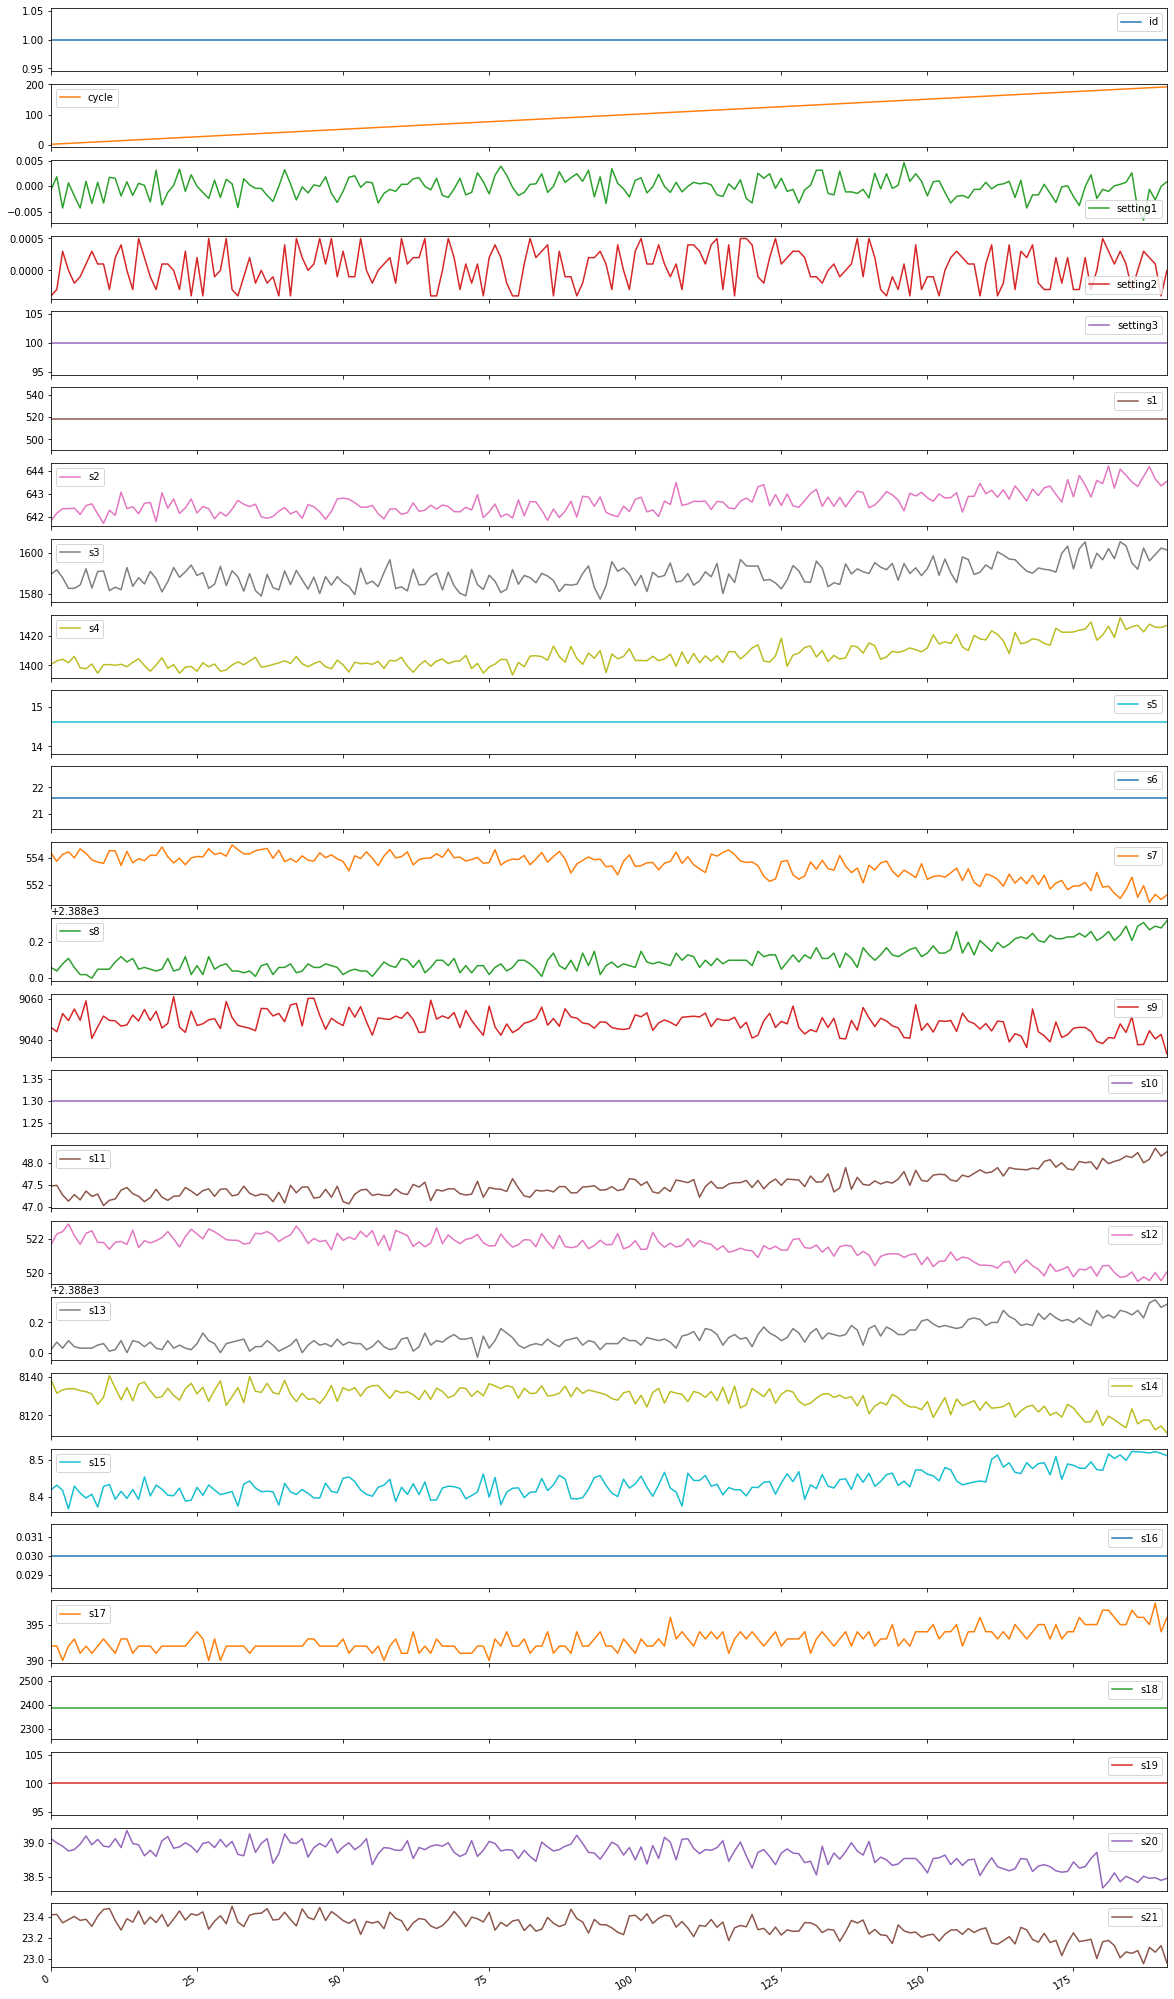

In [0]:
selected_df = train_df[train_df['id']==1]
selected_df.plot(subplots=True, legend=True, figsize = (20,40))
plt.show()

### Preprocessing

#### Training Set

Calculate the RUL for each machine id based on cycle
The initial cycle has the full RUL and it decreases to 0 when it reaches the last cycle.

In [0]:
max_rul = pd.DataFrame(train_df.groupby('id').max()).reset_index()# get the max cycle from each machine id
train_df = train_df.merge(max_rul[['id', 'cycle']], on='id') #merge 2 table together
train_df['rul'] = train_df['cycle_y'] - train_df['cycle_x'] #calculate the rul value
train_df.rename(columns={"cycle_x": "cycle"}, inplace=True)#rename cycle_x to cycle
train_df.drop(columns = train_df[['cycle_y']], axis = 1, inplace = True) #remove the max rul value

Classify the RUL column base.

For example, 
* class 0 =  more than 30 days of RUL
* class 1 =  less than 30 days of RUL
* class 2 =  less than 15 days of RUL

In [0]:
train_df['rul_class'] = train_df.rul.apply(lambda x: 0 if x > 30 else (1 if x > 15 else 2 ))

print("class 0: ", set(train_df[train_df['rul_class']==0].rul))
print("class 1: ", set(train_df[train_df['rul_class']==1].rul))
print("class 2: ", set(train_df[train_df['rul_class']==2].rul))

train_df.drop(columns=train_df[['rul']], axis=1, inplace=True) #remove the rul

class 0:  {31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242

Perform min max scaling since each column has different range of values. We can normalize the value between 0 and 1.

In [0]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
columns_to_scale = train_df.columns[1:-1]
train_df[columns_to_scale] = sc.fit_transform(train_df[columns_to_scale]) #normalize train df
test_df[columns_to_scale] = sc.transform(test_df[columns_to_scale]) #normalize test df

In [0]:
train_df.head(5)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul_class
0,1,0.00000,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,0
1,1,0.00277,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,0
2,1,0.00554,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,0
3,1,0.00831,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,0
4,1,0.01108,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,0


#### Test Set

In [0]:
rul_df['id'] = rul_df.index + 1 #add machine ID to the rul_df (true label)
max_rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()# get the max cycle from each machine id
rul_df['max_rul'] = max_rul['cycle'] + rul_df['remaining_rul'] #add the rul to remaining rul to get maximum rul
test_df = test_df.merge(rul_df[['id', 'max_rul']], how='left', on='id') #merge the truth maximum rul value back to the test_df
test_df['rul'] = test_df['max_rul'] - test_df['cycle'] #calculate rul for each label
test_df['rul_class'] = test_df.rul.apply(lambda x: 0 if x >= 30 else (1 if x >= 15 else 2 ))
test_df.drop(columns=test_df[['max_rul','rul']], axis=1, inplace=True)

#### Preprocess data for LSTM

In [0]:
data_process = []
labels = []
TIME_STEP = 1
SEGMENTATION_TIME_SIZE = 50 #windows size

for id in train_df.id.unique(): #loop through every id
  df_selected_id = train_df[train_df['id']==id]
  '''
  for each id segment out a certain time step, here the time step is 50.
  we need to shape it to tensor with shape [num_samples, time_step, features] before training them with LSTM.
  but before that, all data are segmented using sliding window technique
  training set features
  [
    [data_row[0], data_row[1], ... data_row[49]],
    [data_row[1], data_row[2], ... data_row[50]],
    [data_row[2], data_row[3], ... data_row[51]],
                        .
                        .
                        .
  ]
  training set labels
  [
    [data_row[50]],
    [data_row[51]],
          .
          .
          .
  ]

  '''
  for i in range(0, len(df_selected_id) - SEGMENTATION_TIME_SIZE, TIME_STEP): 
    cycle = df_selected_id['cycle'].values[i: i + SEGMENTATION_TIME_SIZE]
    setting_1 = df_selected_id['setting1'].values[i: i + SEGMENTATION_TIME_SIZE]
    setting_2 = df_selected_id['setting2'].values[i: i + SEGMENTATION_TIME_SIZE]
    setting_3 = df_selected_id['setting3'].values[i: i + SEGMENTATION_TIME_SIZE]
    s1 = df_selected_id['s1'].values[i: i + SEGMENTATION_TIME_SIZE]
    s2 = df_selected_id['s2'].values[i: i + SEGMENTATION_TIME_SIZE]
    s3 = df_selected_id['s3'].values[i: i + SEGMENTATION_TIME_SIZE]
    s4 = df_selected_id['s4'].values[i: i + SEGMENTATION_TIME_SIZE]
    s5 = df_selected_id['s5'].values[i: i + SEGMENTATION_TIME_SIZE]
    s6 = df_selected_id['s6'].values[i: i + SEGMENTATION_TIME_SIZE]
    s7 = df_selected_id['s7'].values[i: i + SEGMENTATION_TIME_SIZE]
    s8 = df_selected_id['s8'].values[i: i + SEGMENTATION_TIME_SIZE]
    s9 = df_selected_id['s9'].values[i: i + SEGMENTATION_TIME_SIZE]
    s10 = df_selected_id['s10'].values[i: i + SEGMENTATION_TIME_SIZE]
    s11 = df_selected_id['s11'].values[i: i + SEGMENTATION_TIME_SIZE]
    s12 = df_selected_id['s12'].values[i: i + SEGMENTATION_TIME_SIZE]
    s13 = df_selected_id['s13'].values[i: i + SEGMENTATION_TIME_SIZE]
    s14 = df_selected_id['s14'].values[i: i + SEGMENTATION_TIME_SIZE]
    s15 = df_selected_id['s15'].values[i: i + SEGMENTATION_TIME_SIZE]
    s16 = df_selected_id['s16'].values[i: i + SEGMENTATION_TIME_SIZE]
    s17 = df_selected_id['s17'].values[i: i + SEGMENTATION_TIME_SIZE]
    s18 = df_selected_id['s18'].values[i: i + SEGMENTATION_TIME_SIZE]
    s19 = df_selected_id['s19'].values[i: i + SEGMENTATION_TIME_SIZE]
    s20 = df_selected_id['s20'].values[i: i + SEGMENTATION_TIME_SIZE]
    s21 = df_selected_id['s21'].values[i: i + SEGMENTATION_TIME_SIZE]
    data_process.append([cycle, setting_1, setting_2, setting_3, s1, s2, s3, s4, s5, s6, s7, s8, s9, s10,
                        s11, s12, s13, s14, s15, s16, s17, s18, s19, s20, s21])
  label_vector = df_selected_id.rul_class.values
  num_elements_in_vector = label_vector.shape[0]
  label_for_next_time_step = label_vector[SEGMENTATION_TIME_SIZE:num_elements_in_vector]
  labels.append(label_for_next_time_step)

In [0]:
trainX = np.asarray(data_process, dtype=np.float32).transpose(0,2,1)
trainy = np.concatenate(labels).astype(np.float32)
trainy = np.expand_dims(trainy, axis=1)
from tensorflow.keras.utils import to_categorical
trainy = to_categorical(trainy)
print(trainX.shape)
print(trainy.shape)

(15631, 50, 25)
(15631, 3)


In [0]:
data_process = []
labels = []

for id in test_df.id.unique(): #loop through every id
  df_selected_id = test_df[test_df['id']==id]
  if len(df_selected_id) >= SEGMENTATION_TIME_SIZE:
    cycle = df_selected_id['cycle'].values[-SEGMENTATION_TIME_SIZE:]
    setting_1 = df_selected_id['setting1'].values[-SEGMENTATION_TIME_SIZE:]
    setting_2 = df_selected_id['setting2'].values[-SEGMENTATION_TIME_SIZE:]
    setting_3 = df_selected_id['setting3'].values[-SEGMENTATION_TIME_SIZE:]
    s1 = df_selected_id['s1'].values[-SEGMENTATION_TIME_SIZE:]
    s2 = df_selected_id['s2'].values[-SEGMENTATION_TIME_SIZE:]
    s3 = df_selected_id['s3'].values[-SEGMENTATION_TIME_SIZE:]
    s4 = df_selected_id['s4'].values[-SEGMENTATION_TIME_SIZE:]
    s5 = df_selected_id['s5'].values[-SEGMENTATION_TIME_SIZE:]
    s6 = df_selected_id['s6'].values[-SEGMENTATION_TIME_SIZE:]
    s7 = df_selected_id['s7'].values[-SEGMENTATION_TIME_SIZE:]
    s8 = df_selected_id['s8'].values[-SEGMENTATION_TIME_SIZE:]
    s9 = df_selected_id['s9'].values[-SEGMENTATION_TIME_SIZE:]
    s10 = df_selected_id['s10'].values[-SEGMENTATION_TIME_SIZE:]
    s11 = df_selected_id['s11'].values[-SEGMENTATION_TIME_SIZE:]
    s12 = df_selected_id['s12'].values[-SEGMENTATION_TIME_SIZE:]
    s13 = df_selected_id['s13'].values[-SEGMENTATION_TIME_SIZE:]
    s14 = df_selected_id['s14'].values[-SEGMENTATION_TIME_SIZE:]
    s15 = df_selected_id['s15'].values[-SEGMENTATION_TIME_SIZE:]
    s16 = df_selected_id['s16'].values[-SEGMENTATION_TIME_SIZE:]
    s17 = df_selected_id['s17'].values[-SEGMENTATION_TIME_SIZE:]
    s18 = df_selected_id['s18'].values[-SEGMENTATION_TIME_SIZE:]
    s19 = df_selected_id['s19'].values[-SEGMENTATION_TIME_SIZE:]
    s20 = df_selected_id['s20'].values[-SEGMENTATION_TIME_SIZE:]
    s21 = df_selected_id['s21'].values[-SEGMENTATION_TIME_SIZE:]
    data_process.append([cycle, setting_1, setting_2, setting_3, s1, s2, s3, s4, s5, s6, s7, s8, s9, s10,
                        s11, s12, s13, s14, s15, s16, s17, s18, s19, s20, s21])
    label_vector = df_selected_id.rul_class.values
    num_elements_in_vector = label_vector.shape[0]
    label_for_next_time_step = label_vector[-1]
    labels.append(label_for_next_time_step)

In [0]:
testX = np.asarray(data_process, dtype=np.float32).transpose(0,2,1)
testy = np.asarray(labels)
testy = np.expand_dims(testy, axis=1)

testy = to_categorical(testy)
print(testX.shape)
print(testy.shape)

(93, 50, 25)
(93, 3)


### Create LSTM

In [0]:
import tensorflow as tf

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(50, input_shape=trainX.shape[1:], return_sequences=True),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.LSTM(50, input_shape=trainX.shape[1:]),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            15200     
_________________________________________________________________
dropout (Dropout)            (None, 50, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 35,943
Trainable params: 35,943
Non-trainable params: 0
_________________________________________________________________
None


### Model Training

In [0]:
hist = model.fit(trainX, trainy,batch_size=64,epochs=10,validation_split= 0.3,
          callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       tf.keras.callbacks.ModelCheckpoint('model.h5',monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 10941 samples, validate on 4690 samples
Epoch 1/10
10941/10941 [==============================] - 21s 2ms/sample - loss: 0.3389 - acc: 0.8623 - val_loss: 0.1577 - val_acc: 0.9362
Epoch 2/10
10941/10941 [==============================] - 19s 2ms/sample - loss: 0.1489 - acc: 0.9374 - val_loss: 0.1098 - val_acc: 0.9527
Epoch 3/10
10941/10941 [==============================] - 19s 2ms/sample - loss: 0.1300 - acc: 0.9451 - val_loss: 0.1367 - val_acc: 0.9377
Epoch 4/10
10941/10941 [==============================] - 19s 2ms/sample - loss: 0.1283 - acc: 0.9442 - val_loss: 0.1066 - val_acc: 0.9527
Epoch 5/10
10941/10941 [==============================] - 19s 2ms/sample - loss: 0.1112 - acc: 0.9521 - val_loss: 0.0964 - val_acc: 0.9569
Epoch 6/10
10941/10941 [==============================] - 20s 2ms/sample - loss: 0.1058 - acc: 0.9558 - val_loss: 0.1284 - val_acc: 0.9469
Epoch 7/10
10941/10941 

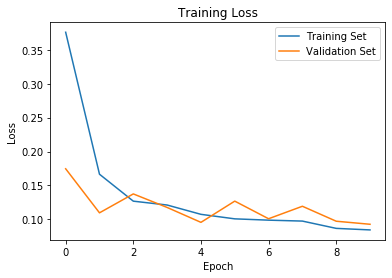

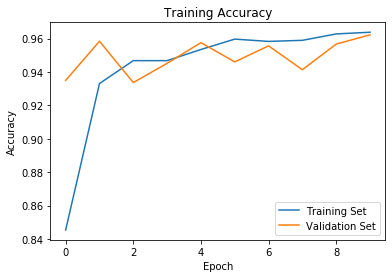

In [0]:
#print(hist.history)

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Set', 'Validation Set'])
plt.show()

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Set', 'Validation Set'])
plt.show()

### Model validation with Test Set

In [0]:
#model = load_model('model.h5')
from sklearn.metrics import classification_report, f1_score

model.evaluate(testX, testy)
predict_y = model.predict(testX, batch_size=32)
predict_y_bool = np.argmax(predict_y, axis=1)
true_label_y = np.argmax(testy, axis=1)
true_label_y
print(classification_report(true_label_y, predict_y_bool))
print('f1 score: ', f1_score(true_label_y, predict_y_bool, average='weighted'))

93/93 [==============================] - 0s 884us/sample - loss: 0.1202 - acc: 0.9570
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        68
           1       0.88      0.88      0.88        16
           2       0.82      1.00      0.90         9

    accuracy                           0.96        93
   macro avg       0.90      0.95      0.92        93
weighted avg       0.96      0.96      0.96        93

f1 score:  0.9579040282458673


## Regression Method

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
np.random.seed(123)  
PYTHONHASHSEED = 0

%matplotlib inline

### Read and Load Data

In [0]:
parent_url = 'https://raw.githubusercontent.com/jingzhi93/Nasa-TurboFan-Predictive-Maintanence/master/CMAPSSData/'

column_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = pd.read_csv(parent_url+'train_FD001.txt', sep = " ", header=None)
train_df.drop(columns=train_df.columns[[26,27]], inplace=True)
train_df.columns = column_names

test_df = pd.read_csv(parent_url+'test_FD001.txt', sep = " ", header=None)
test_df.drop(columns=test_df.columns[[26,27]], inplace=True)
test_df.columns = column_names

rul_df = pd.read_csv(parent_url+'RUL_FD001.txt', sep = " ", header=None)
rul_df.drop(columns=rul_df.columns[[1]], axis=1, inplace=True)
rul_df.columns = ['remaining_rul']

train_df.astype('float32')
test_df.astype('float32')

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1.0,1.0,0.0023,0.0003,100.0,518.669983,643.020020,1585.290039,1398.209961,14.62,21.610001,553.900024,2388.040039,9050.169922,1.3,47.200001,521.719971,2388.030029,8125.549805,8.4052,0.03,392.0,2388.0,100.0,38.860001,23.373501
1,1.0,2.0,-0.0027,-0.0003,100.0,518.669983,641.710022,1588.449951,1395.420044,14.62,21.610001,554.849976,2388.010010,9054.419922,1.3,47.500000,522.159973,2388.060059,8139.620117,8.3803,0.03,393.0,2388.0,100.0,39.020000,23.391600
2,1.0,3.0,0.0003,0.0001,100.0,518.669983,642.460022,1586.939941,1401.339966,14.62,21.610001,554.109985,2388.050049,9056.959961,1.3,47.500000,521.969971,2388.030029,8130.100098,8.4441,0.03,393.0,2388.0,100.0,39.080002,23.416599
3,1.0,4.0,0.0042,0.0000,100.0,518.669983,642.440002,1584.119995,1406.420044,14.62,21.610001,554.070007,2388.030029,9045.290039,1.3,47.279999,521.380005,2388.050049,8132.899902,8.3917,0.03,391.0,2388.0,100.0,39.000000,23.373699
4,1.0,5.0,0.0014,0.0000,100.0,518.669983,642.510010,1587.189941,1401.920044,14.62,21.610001,554.159973,2388.010010,9044.549805,1.3,47.310001,522.150024,2388.030029,8129.540039,8.4031,0.03,390.0,2388.0,100.0,38.990002,23.413000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100.0,194.0,0.0049,0.0000,100.0,518.669983,643.239990,1599.449951,1415.790039,14.62,21.610001,553.409973,2388.020020,9142.370117,1.3,47.689999,520.690002,2388.000000,8213.280273,8.4715,0.03,394.0,2388.0,100.0,38.650002,23.197399
13092,100.0,195.0,-0.0011,-0.0001,100.0,518.669983,643.219971,1595.689941,1422.050049,14.62,21.610001,553.219971,2388.050049,9140.679688,1.3,47.599998,521.049988,2388.090088,8210.849609,8.4512,0.03,395.0,2388.0,100.0,38.570000,23.277100
13093,100.0,196.0,-0.0006,-0.0003,100.0,518.669983,643.440002,1593.150024,1406.819946,14.62,21.610001,553.039978,2388.110107,9146.809570,1.3,47.570000,521.179993,2388.040039,8217.240234,8.4569,0.03,395.0,2388.0,100.0,38.619999,23.205099
13094,100.0,197.0,-0.0038,0.0001,100.0,518.669983,643.260010,1594.989990,1419.359985,14.62,21.610001,553.369995,2388.070068,9148.849609,1.3,47.610001,521.330017,2388.080078,8220.480469,8.4711,0.03,395.0,2388.0,100.0,38.660000,23.269899


### Preprocessing

#### Training Set

In [0]:
max_rul = pd.DataFrame(train_df.groupby('id').max()).reset_index()# get the max cycle from each machine id
train_df = train_df.merge(max_rul[['id', 'cycle']], on='id') #merge 2 table together
train_df['rul'] = train_df['cycle_y'] - train_df['cycle_x'] #calculate the rul value
train_df.rename(columns={"cycle_x": "cycle"}, inplace=True)#rename cycle_x to cycle
train_df.drop(columns = train_df[['cycle_y']], axis = 1, inplace = True) #remove the max rul value

In [0]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
columns_to_scale = train_df.columns[1:-1]
train_df[columns_to_scale] = sc.fit_transform(train_df[columns_to_scale]) #normalize train df
test_df[columns_to_scale] = sc.transform(test_df[columns_to_scale]) #normalize test df

#### Test Set

In [0]:
rul_df['id'] = rul_df.index + 1 #add machine ID to the rul_df (true label)
max_rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()# get the max cycle from each machine id
rul_df['max_rul'] = max_rul['cycle'] + rul_df['remaining_rul'] #add the rul to remaining rul to get maximum rul
test_df = test_df.merge(rul_df[['id', 'max_rul']], how='left', on='id') #merge the truth maximum rul value back to the test_df
test_df['rul'] = test_df['max_rul'] - test_df['cycle'] #calculate rul for each label
test_df.drop(columns=test_df[['max_rul']], axis=1, inplace=True)

#### Preprocess data for LSTM

In [0]:
data_process = []
labels = []
TIME_STEP = 1
SEGMENTATION_TIME_SIZE = 50 #windows size

for id in train_df.id.unique(): #loop through every id
  df_selected_id = train_df[train_df['id']==id]
  '''
  for each id segment out a certain time step, here the time step is 50.
  we need to shape it to tensor with shape [num_samples, time_step, features] before training them with LSTM.
  but before that, all data are segmented using sliding window technique
  training set features
  [
    [data_row[0], data_row[1], ... data_row[49]],
    [data_row[1], data_row[2], ... data_row[50]],
    [data_row[2], data_row[3], ... data_row[51]],
                        .
                        .
                        .
  ]
  training set labels
  [
    [data_row[50]],
    [data_row[51]],
          .
          .
          .
  ]

  '''
  for i in range(0, len(df_selected_id) - SEGMENTATION_TIME_SIZE, TIME_STEP): 
    cycle = df_selected_id['cycle'].values[i: i + SEGMENTATION_TIME_SIZE]
    setting_1 = df_selected_id['setting1'].values[i: i + SEGMENTATION_TIME_SIZE]
    setting_2 = df_selected_id['setting2'].values[i: i + SEGMENTATION_TIME_SIZE]
    setting_3 = df_selected_id['setting3'].values[i: i + SEGMENTATION_TIME_SIZE]
    s1 = df_selected_id['s1'].values[i: i + SEGMENTATION_TIME_SIZE]
    s2 = df_selected_id['s2'].values[i: i + SEGMENTATION_TIME_SIZE]
    s3 = df_selected_id['s3'].values[i: i + SEGMENTATION_TIME_SIZE]
    s4 = df_selected_id['s4'].values[i: i + SEGMENTATION_TIME_SIZE]
    s5 = df_selected_id['s5'].values[i: i + SEGMENTATION_TIME_SIZE]
    s6 = df_selected_id['s6'].values[i: i + SEGMENTATION_TIME_SIZE]
    s7 = df_selected_id['s7'].values[i: i + SEGMENTATION_TIME_SIZE]
    s8 = df_selected_id['s8'].values[i: i + SEGMENTATION_TIME_SIZE]
    s9 = df_selected_id['s9'].values[i: i + SEGMENTATION_TIME_SIZE]
    s10 = df_selected_id['s10'].values[i: i + SEGMENTATION_TIME_SIZE]
    s11 = df_selected_id['s11'].values[i: i + SEGMENTATION_TIME_SIZE]
    s12 = df_selected_id['s12'].values[i: i + SEGMENTATION_TIME_SIZE]
    s13 = df_selected_id['s13'].values[i: i + SEGMENTATION_TIME_SIZE]
    s14 = df_selected_id['s14'].values[i: i + SEGMENTATION_TIME_SIZE]
    s15 = df_selected_id['s15'].values[i: i + SEGMENTATION_TIME_SIZE]
    s16 = df_selected_id['s16'].values[i: i + SEGMENTATION_TIME_SIZE]
    s17 = df_selected_id['s17'].values[i: i + SEGMENTATION_TIME_SIZE]
    s18 = df_selected_id['s18'].values[i: i + SEGMENTATION_TIME_SIZE]
    s19 = df_selected_id['s19'].values[i: i + SEGMENTATION_TIME_SIZE]
    s20 = df_selected_id['s20'].values[i: i + SEGMENTATION_TIME_SIZE]
    s21 = df_selected_id['s21'].values[i: i + SEGMENTATION_TIME_SIZE]
    data_process.append([cycle, setting_1, setting_2, setting_3, s1, s2, s3, s4, s5, s6, s7, s8, s9, s10,
                        s11, s12, s13, s14, s15, s16, s17, s18, s19, s20, s21])
  label_vector = df_selected_id.rul.values
  num_elements_in_vector = label_vector.shape[0]
  label_for_next_time_step = label_vector[SEGMENTATION_TIME_SIZE:num_elements_in_vector]
  labels.append(label_for_next_time_step)

In [0]:
trainX = np.asarray(data_process, dtype=np.float32).transpose(0,2,1)
trainy = np.concatenate(labels).astype(np.float32)
trainy = np.expand_dims(trainy, axis=1)
print(trainX.shape)
print(trainy.shape)

(15631, 50, 25)
(15631, 1)


In [0]:
data_process = []
labels = []

for id in test_df.id.unique(): #loop through every id
  df_selected_id = test_df[test_df['id']==id]
  if len(df_selected_id) >= SEGMENTATION_TIME_SIZE:
    cycle = df_selected_id['cycle'].values[-SEGMENTATION_TIME_SIZE:]
    setting_1 = df_selected_id['setting1'].values[-SEGMENTATION_TIME_SIZE:]
    setting_2 = df_selected_id['setting2'].values[-SEGMENTATION_TIME_SIZE:]
    setting_3 = df_selected_id['setting3'].values[-SEGMENTATION_TIME_SIZE:]
    s1 = df_selected_id['s1'].values[-SEGMENTATION_TIME_SIZE:]
    s2 = df_selected_id['s2'].values[-SEGMENTATION_TIME_SIZE:]
    s3 = df_selected_id['s3'].values[-SEGMENTATION_TIME_SIZE:]
    s4 = df_selected_id['s4'].values[-SEGMENTATION_TIME_SIZE:]
    s5 = df_selected_id['s5'].values[-SEGMENTATION_TIME_SIZE:]
    s6 = df_selected_id['s6'].values[-SEGMENTATION_TIME_SIZE:]
    s7 = df_selected_id['s7'].values[-SEGMENTATION_TIME_SIZE:]
    s8 = df_selected_id['s8'].values[-SEGMENTATION_TIME_SIZE:]
    s9 = df_selected_id['s9'].values[-SEGMENTATION_TIME_SIZE:]
    s10 = df_selected_id['s10'].values[-SEGMENTATION_TIME_SIZE:]
    s11 = df_selected_id['s11'].values[-SEGMENTATION_TIME_SIZE:]
    s12 = df_selected_id['s12'].values[-SEGMENTATION_TIME_SIZE:]
    s13 = df_selected_id['s13'].values[-SEGMENTATION_TIME_SIZE:]
    s14 = df_selected_id['s14'].values[-SEGMENTATION_TIME_SIZE:]
    s15 = df_selected_id['s15'].values[-SEGMENTATION_TIME_SIZE:]
    s16 = df_selected_id['s16'].values[-SEGMENTATION_TIME_SIZE:]
    s17 = df_selected_id['s17'].values[-SEGMENTATION_TIME_SIZE:]
    s18 = df_selected_id['s18'].values[-SEGMENTATION_TIME_SIZE:]
    s19 = df_selected_id['s19'].values[-SEGMENTATION_TIME_SIZE:]
    s20 = df_selected_id['s20'].values[-SEGMENTATION_TIME_SIZE:]
    s21 = df_selected_id['s21'].values[-SEGMENTATION_TIME_SIZE:]
    data_process.append([cycle, setting_1, setting_2, setting_3, s1, s2, s3, s4, s5, s6, s7, s8, s9, s10,
                        s11, s12, s13, s14, s15, s16, s17, s18, s19, s20, s21])
    label_vector = df_selected_id.rul.values
    num_elements_in_vector = label_vector.shape[0]
    label_for_next_time_step = label_vector[-1]
    labels.append(label_for_next_time_step)

In [0]:
testX = np.asarray(data_process, dtype=np.float32).transpose(0,2,1)
testy = np.asarray(labels)
testy = np.expand_dims(testy, axis=1)
print(testX.shape)
print(testy.shape)

(93, 50, 25)
(93, 1)


### Create LSTM

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(50, input_shape=trainX.shape[1:], return_sequences=True),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.LSTM(50),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 50)            15200     
_________________________________________________________________
dropout (Dropout)            (None, 50, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 35,921
Trainable params: 35,921
Non-trainable params: 0
_________________________________________________________________
None


### Model Training

In [0]:
hist = model.fit(trainX, trainy,batch_size=64,epochs=10,validation_split= 0.3,
          callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       tf.keras.callbacks.ModelCheckpoint('model_reg.h5',monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Train on 10941 samples, validate on 4690 samples
Epoch 1/10
10941/10941 [==============================] - 21s 2ms/sample - loss: 8121.3706 - mean_absolute_error: 72.3973 - val_loss: 8849.6562 - val_mean_absolute_error: 73.2906
Epoch 2/10
10941/10941 [==============================] - 19s 2ms/sample - loss: 5266.8313 - mean_absolute_error: 55.5341 - val_loss: 5681.4482 - val_mean_absolute_error: 57.1847
Epoch 3/10
10941/10941 [==============================] - 19s 2ms/sample - loss: 3425.8843 - mean_absolute_error: 45.5424 - val_loss: 4258.3621 - val_mean_absolute_error: 50.9871
Epoch 4/10
10941/10941 [==============================] - 19s 2ms/sample - loss: 3001.4318 - mean_absolute_error: 43.9534 - val_loss: 3998.9695 - val_mean_absolute_error: 50.2868
Epoch 5/10
10941/10941 [==============================] - 19s 2ms/sample - loss: 2975.6261 - mean_absolute_error: 44.0993 - val_loss: 3971.1507 - val_mean_absolute_error: 50.2550
Epoch 6/10
10941/10941 [==============================] 

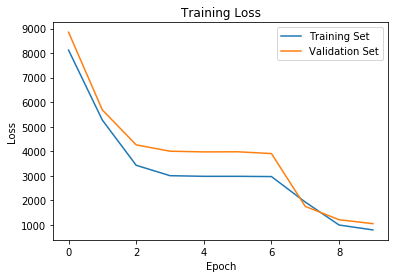

In [0]:
#print(hist.history)

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Set', 'Validation Set'])
plt.show()

### Model validation with Test Set

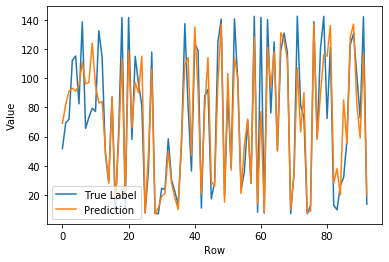

In [0]:
model.load_weights('model_reg.h5')
predict_y = model.predict(testX, batch_size=32)
plt.plot(predict_y)
plt.plot(testy)
plt.xlabel('Row')
plt.ylabel('Value')
plt.legend(['True Label', 'Prediction'])
plt.show()

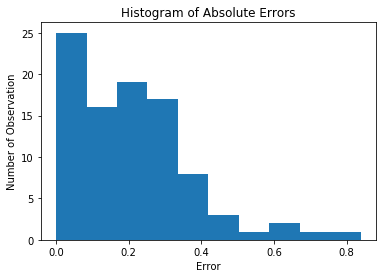

In [0]:
plt.hist(np.abs((predict_y - testy)/testy))
plt.xlabel('Error')
plt.ylabel('Number of Observation')
plt.title('Histogram of Absolute Errors')
plt.show()

# References

[1] Dataset: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan </p>
[2] https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-1-of-3-data-preparation-and-feature-engineering-2